# Features for Microglia in P6 mouse Cortex

In [1]:
!pip install scProject -U
import random
random.seed(a=613)
import numpy as np
import scProject
import scanpy as sc
patterns = sc.read_h5ad('patterns_anndata.h5ad')
dataset = sc.read_h5ad('test_target.h5ad')
dataset.X[dataset.X<0] = 0
dataset_filtered, patterns_filtered = scProject.matcher.filterAnnDatas(dataset, patterns, 'gene_id')



Requirement already up-to-date: scProject in /Users/asherbaraban/opt/anaconda3/lib/python3.7/site-packages (1.0.9.892)
(55371, 428) dataset filter shape
(80, 428) patterns filter shape


Trying to set attribute `.X` of view, copying.
Trying to set attribute `.X` of view, copying.


Low regularization low 1% lasso

A layer named 'log' has been added to your filtered dataset
Regressing on loglayer of dataset_filtered
(55371, 80)
[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


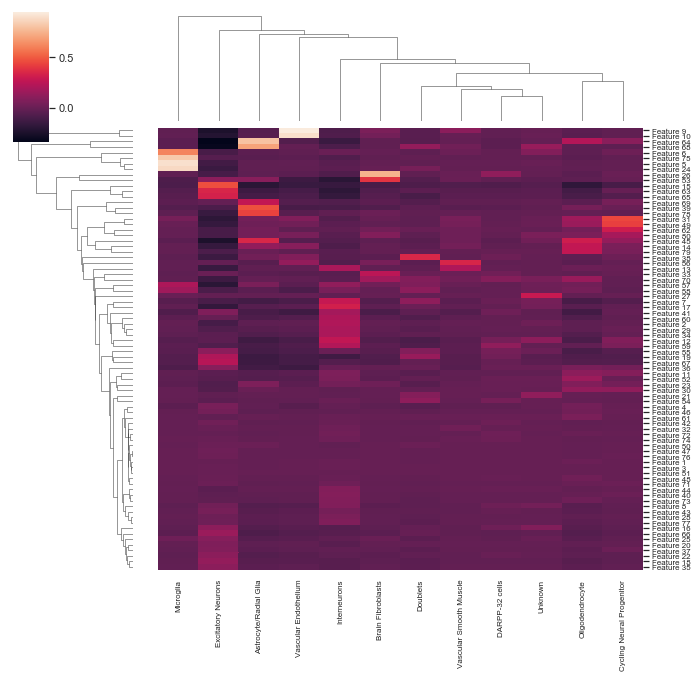

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [10, 12]
dataset_filtered = scProject.matcher.logTransform(dataset_filtered)
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'MG01', .0001, .01, layer='log')
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'CellType', 12, 'MG01', 'MG01Pears', True)

[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


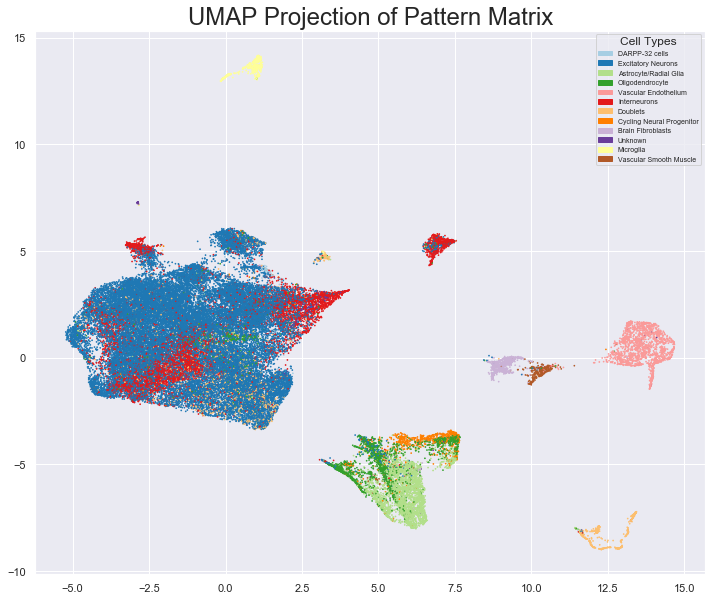

In [3]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'CellType', 'MG01', 'UMAPMG01', 20)

Number of nonzero cells 1561


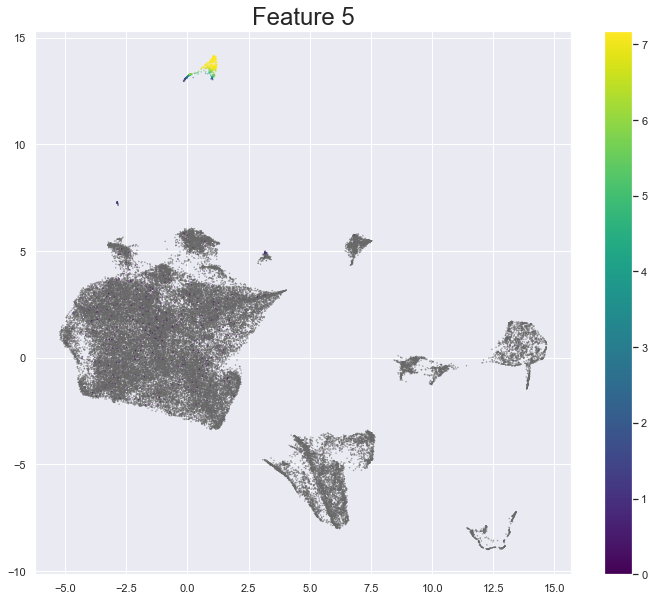

Number of nonzero cells 5257


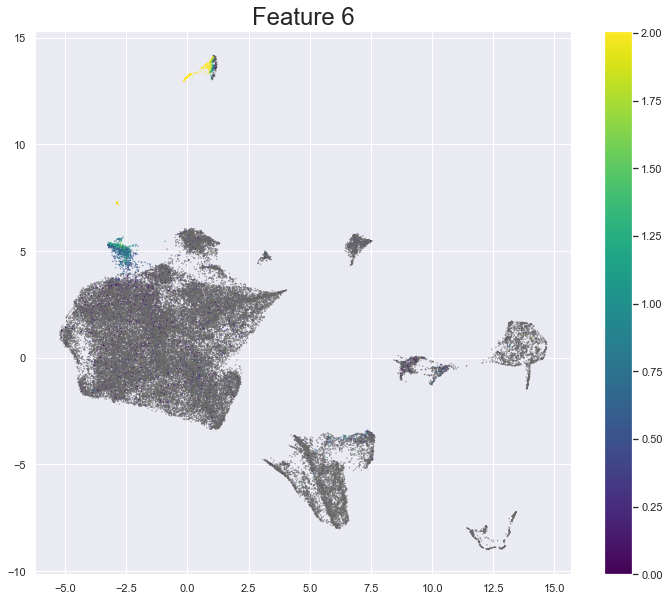

Number of nonzero cells 5213


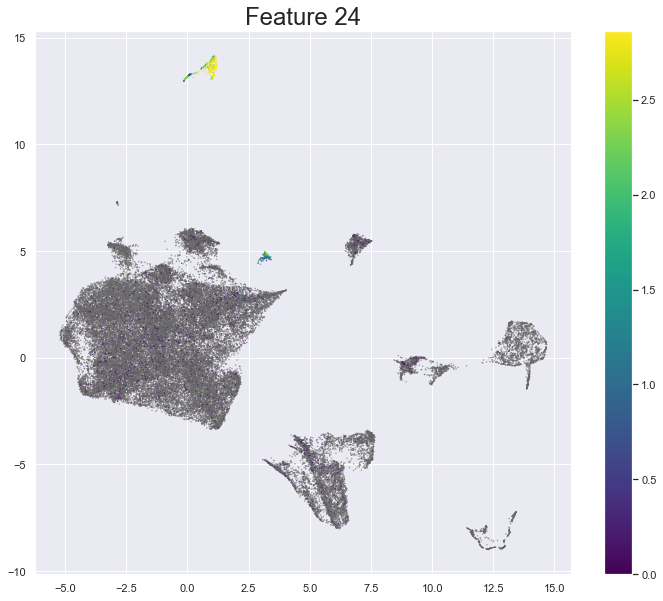

Number of nonzero cells 6096


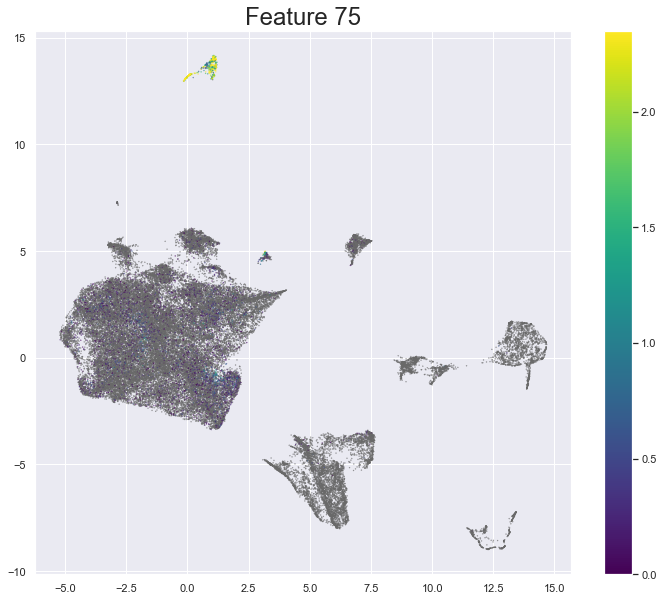

In [4]:
scProject.viz.featurePlots(dataset_filtered, [5, 6, 24, 75], 'MG01', 'UMAPMG01')

As expected from the Pearson plot, features 5 and 24 are the stronger markers of microglia in the P6 mouse cortex. Lets up the lasso to encourage sparsity and strengthen the features that are the real drivers.

Regressing on loglayer of dataset_filtered
(55371, 80)
[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


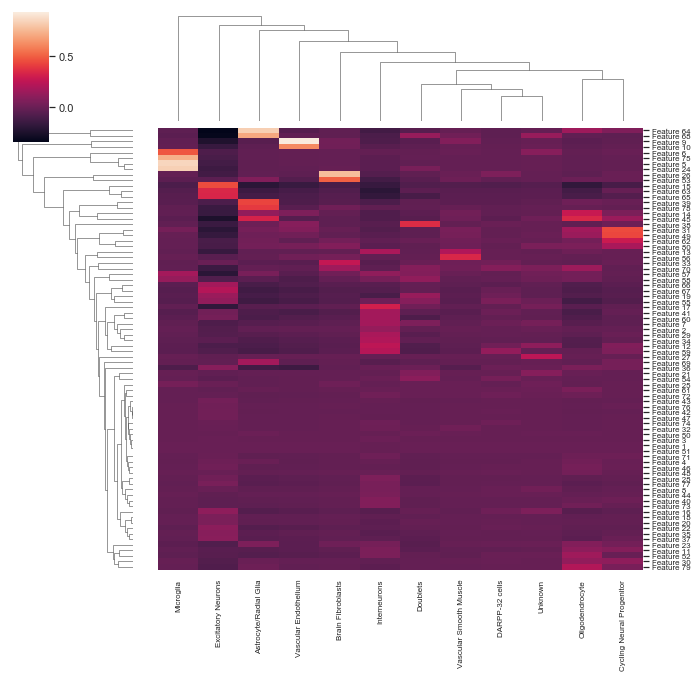

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [10, 12]
scProject.rg.NNLR_ElasticNet(dataset_filtered, patterns_filtered, 'MG99', .0005, .99, layer='log')
scProject.viz.pearsonMatrix(dataset_filtered, patterns_filtered, 'CellType', 12, 'MG99', 'MG99Pears', True)

[DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, Vascular Endothelium, ..., Cycling Neural Progenitor, Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]
Length: 12
Categories (12, object): [DARPP-32 cells, Excitatory Neurons, Astrocyte/Radial Glia, Oligodendrocyte, ..., Brain Fibroblasts, Unknown, Microglia, Vascular Smooth Muscle]


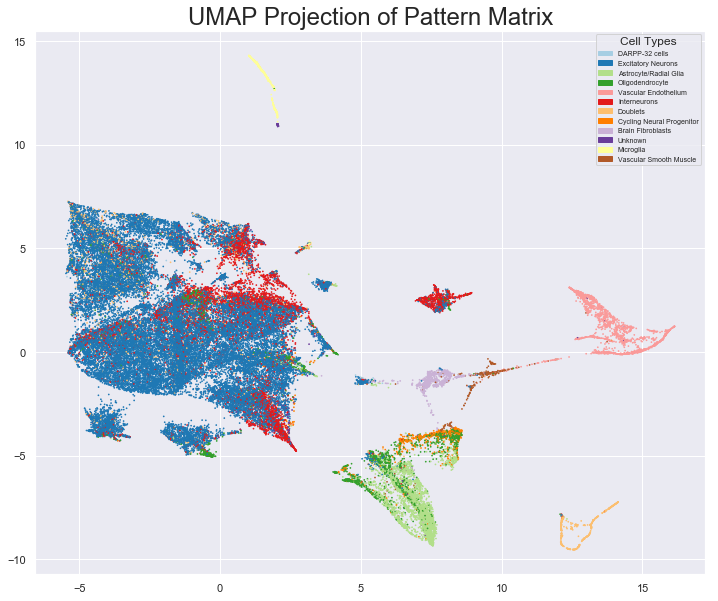

In [6]:
plt.rcParams['figure.figsize']= [12, 10]
scProject.viz.UMAP_Projection(dataset_filtered, 'CellType', 'MG99', 'UMAPMG99', 20)

One nice feature of scProject is that you can use the UMAP coordinates generated from a previous regression. This can be useful when you increase the regularization and the UMAPs become harder to decipher. These are the feature plots, but on the original UMAP coordinates.

Number of nonzero cells 554


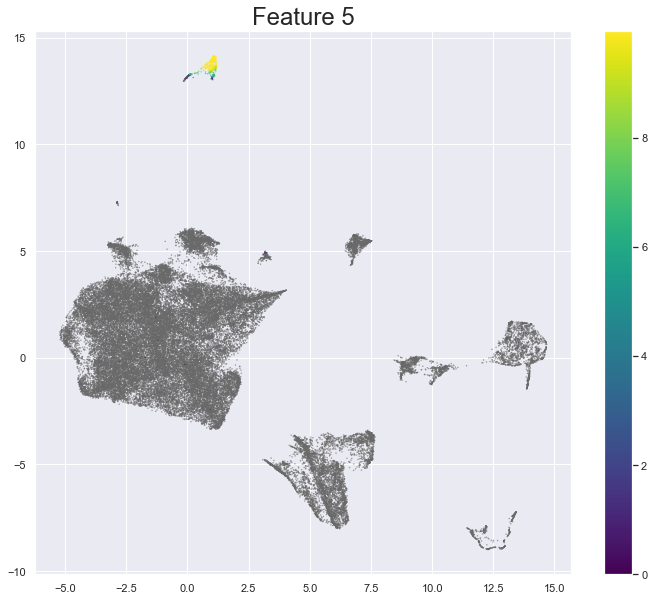

Number of nonzero cells 1202


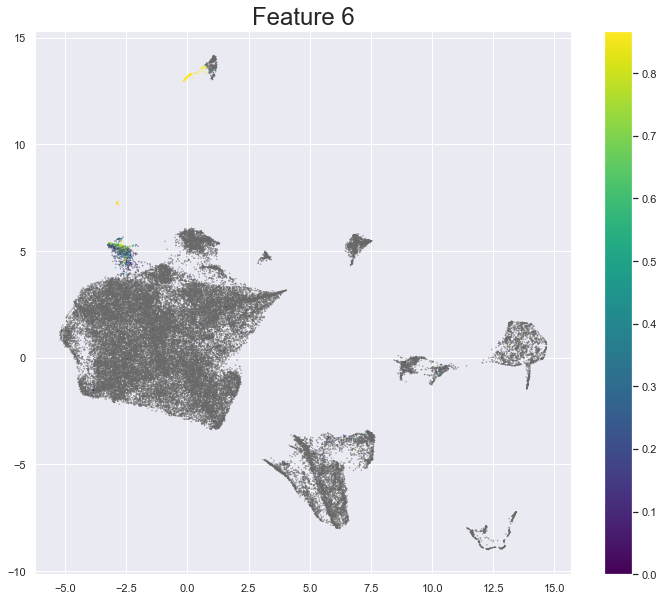

Number of nonzero cells 2078


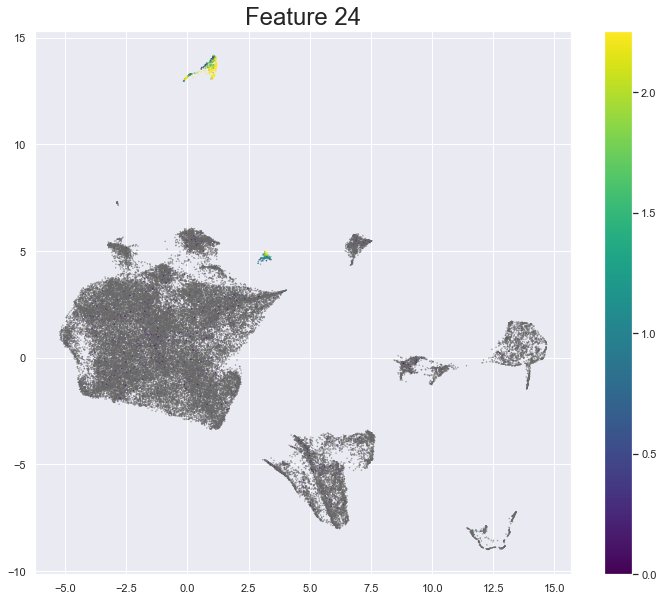

Number of nonzero cells 767


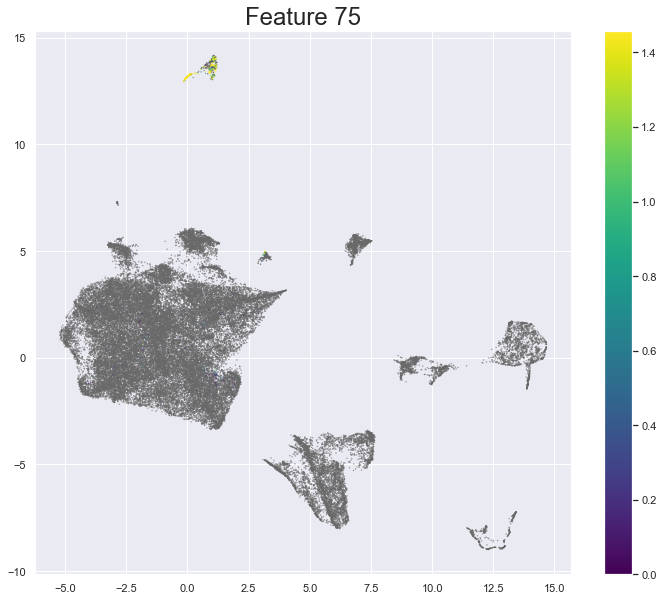

In [7]:
scProject.viz.featurePlots(dataset_filtered, [5, 6, 24, 75], 'MG99', 'UMAPMG01')

This is the typical feature weights on a newly generated UMAP coordinate system.

(582, 80)
Number of nonzero cells 525


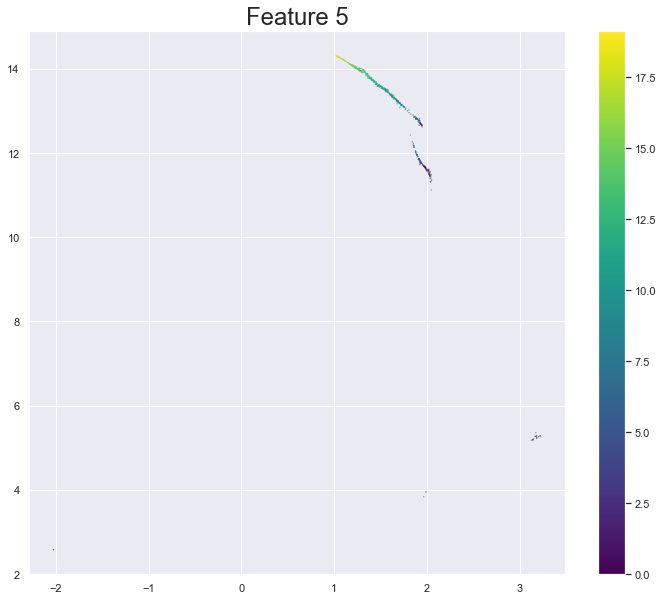

Number of nonzero cells 197


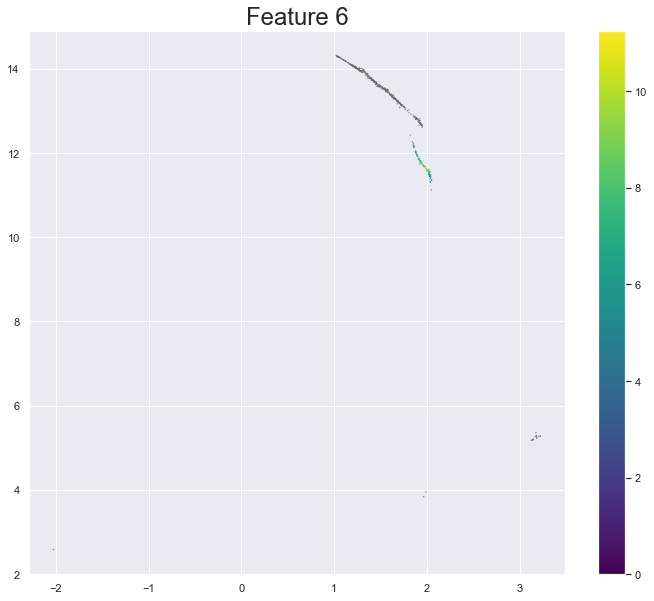

Number of nonzero cells 570


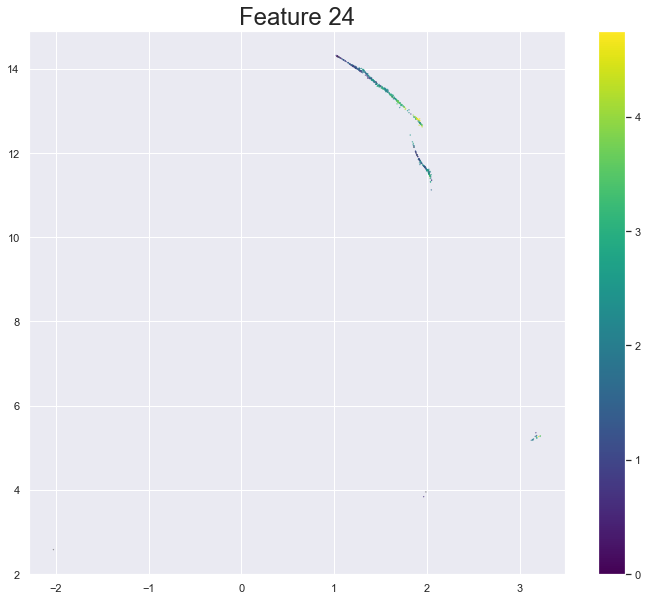

Number of nonzero cells 482


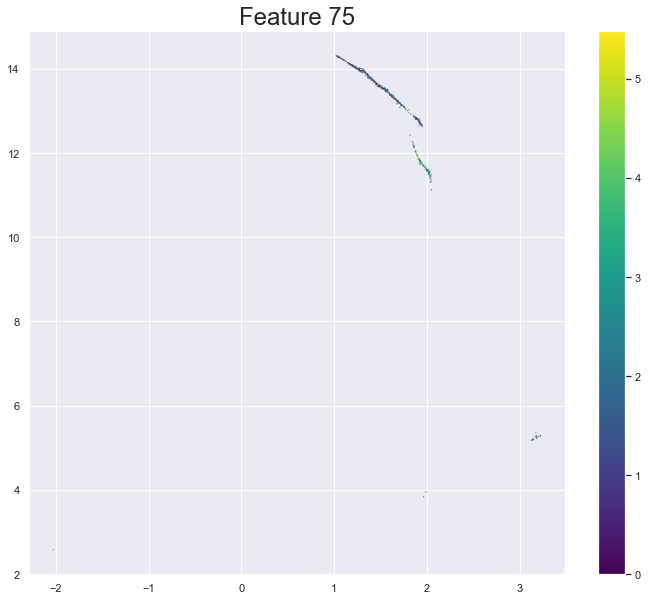

In [8]:
scProject.viz.featurePlots(dataset_filtered, [5, 6, 24, 75], 'MG99', 'UMAPMG99', subset=['Microglia'], obsColumn='CellType')

While this is clearly over regularized some features 5, 6 and 75(because of how many nonzero cells) persist. Lets print out the highest expressed genes from the features of interest and see what's inside.

In [9]:
print(scProject.stats.importantGenes(patterns_filtered, 5, .05), "Feature 5 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 6, .05), "Feature 6 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 24, .1), "Feature 24 Genes")
print(scProject.stats.importantGenes(patterns_filtered, 75, .1), "Feature 75 Genes")

[Index(['ENSMUSG00000026358', 'ENSMUSG00000058715', 'ENSMUSG00000060802',
       'ENSMUSG00000027199', 'ENSMUSG00000027447', 'ENSMUSG00000017707',
       'ENSMUSG00000025283', 'ENSMUSG00000049775', 'ENSMUSG00000038642',
       'ENSMUSG00000028581', 'ENSMUSG00000000682', 'ENSMUSG00000036905',
       'ENSMUSG00000036896', 'ENSMUSG00000029484', 'ENSMUSG00000029580',
       'ENSMUSG00000030220', 'ENSMUSG00000002985', 'ENSMUSG00000030579',
       'ENSMUSG00000030560', 'ENSMUSG00000007891', 'ENSMUSG00000041515',
       'ENSMUSG00000021876', 'ENSMUSG00000021939', 'ENSMUSG00000040204',
       'ENSMUSG00000052336', 'ENSMUSG00000000982', 'ENSMUSG00000018930',
       'ENSMUSG00000005583', 'ENSMUSG00000021665', 'ENSMUSG00000001175',
       'ENSMUSG00000021190', 'ENSMUSG00000033220', 'ENSMUSG00000068220',
       'ENSMUSG00000024397', 'ENSMUSG00000079419', 'ENSMUSG00000024677'],
      dtype='object', name='index')] Feature 5 Genes
[Index(['ENSMUSG00000026126', 'ENSMUSG00000059498', 'ENSMUSG000000587

In short, Feature 24 which is expressed in a fraction of microglia has high expression of C1qa, C1qb, C1qc genes. Feature 24 is not included in all of the microglia suggesting that there exists a subtype of microglia in the P6 mouse cortex that expresses C1qa through c in much higher amounts. Features 5, 6, and 75 do not have the C1qs expressed in their most important genes. This shows a subtyping of microglia in terms of expression of C1q expression.

To better understand the expression of C1q a-c, lets use gene selectivity to understand what the model is doing.

Feature 5 expresses 11.083000153303146% of gene ENSMUSG00000036887
Feature 6 expresses 7.832718640565872% of gene ENSMUSG00000036887
Feature 24 expresses 44.47410702705383% of gene ENSMUSG00000036887


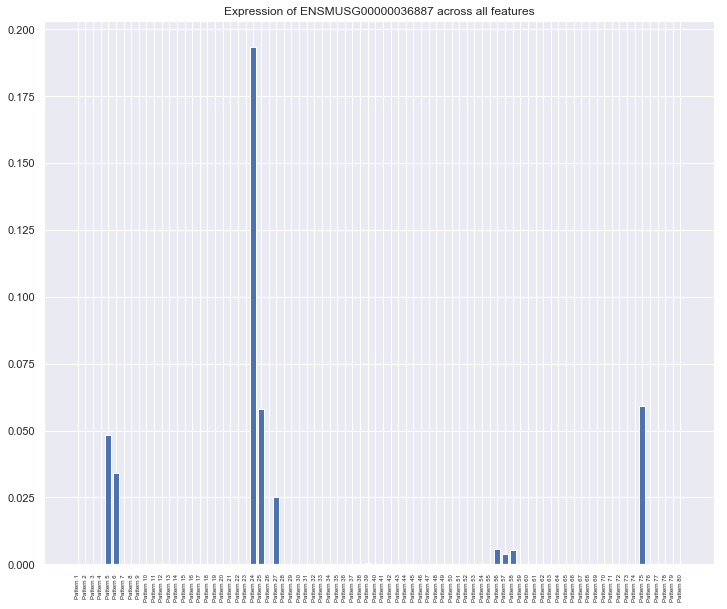

Feature 5 expresses 12.099885195493698% of gene ENSMUSG00000036905
Feature 6 expresses 11.364411562681198% of gene ENSMUSG00000036905
Feature 24 expresses 35.02193987369537% of gene ENSMUSG00000036905


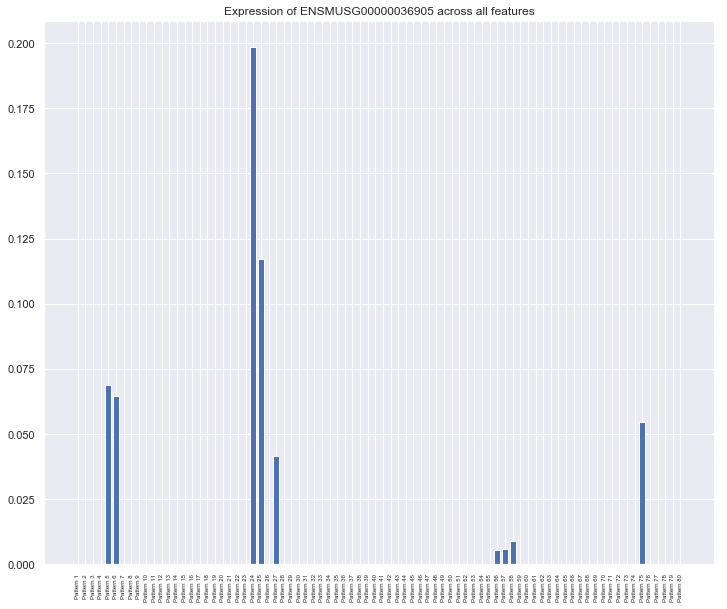

Feature 5 expresses 12.562157213687897% of gene ENSMUSG00000036896
Feature 6 expresses 8.364727348089218% of gene ENSMUSG00000036896
Feature 24 expresses 37.7030223608017% of gene ENSMUSG00000036896


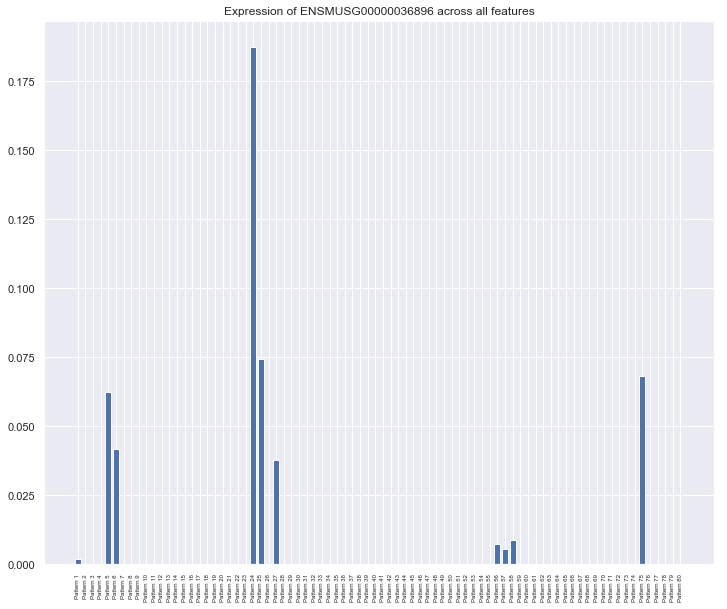

(582, 80)


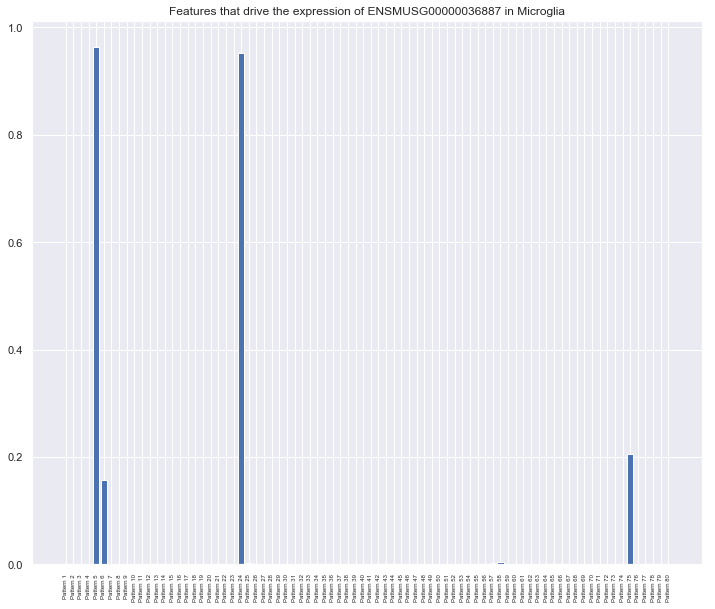

(582, 80)


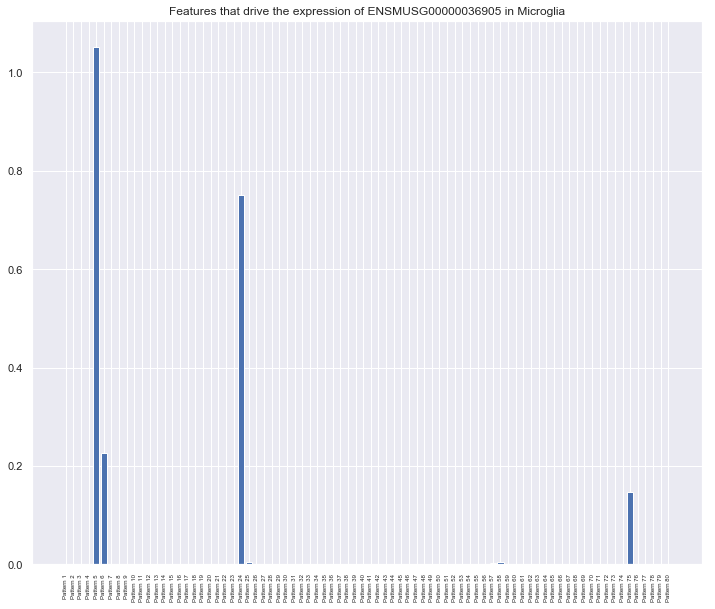

(582, 80)


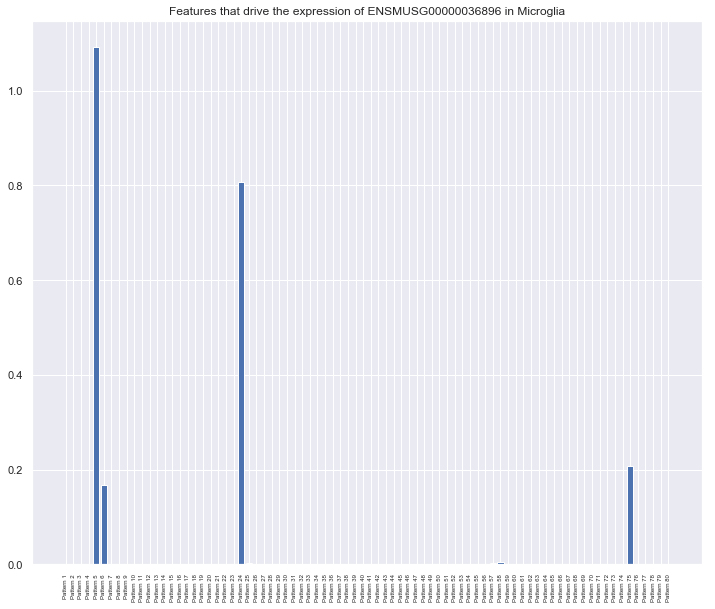

In [10]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 5, False) #C1qa
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 6, False) #C1qa
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036887', 24, True) #C1qa

scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 5, False) #C1qb
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 6, False) #C1qb
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036905', 24, True) #C1qb

scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 5, False) #C1qc
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 6, False) #C1qc
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000036896', 24, True) #C1qc

scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036887', 'CellType',
                                       "Microglia", "MG99")
scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036905', 'CellType',
                                       "Microglia", "MG99")
scProject.stats.geneDriver(dataset_filtered, patterns_filtered, 'ENSMUSG00000036896', 'CellType',
                                       "Microglia", "MG99")

Feature 24 expresses 11.780047416687012% of gene ENSMUSG00000059498


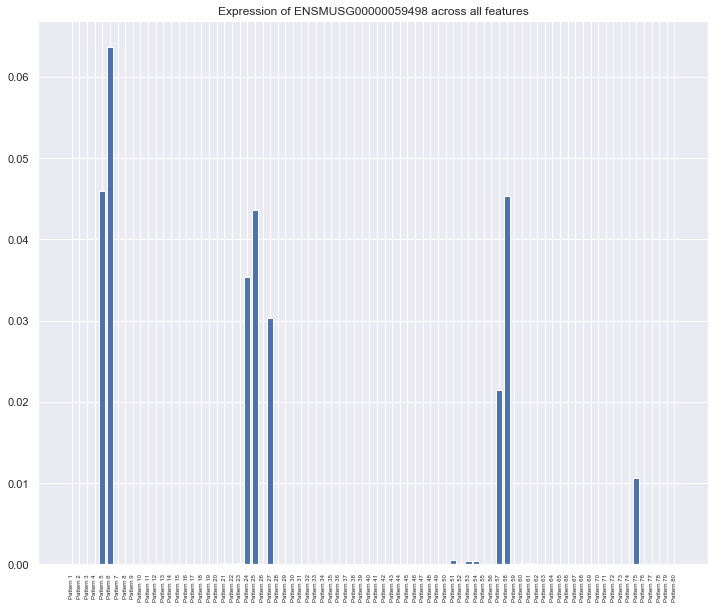

In [11]:
scProject.stats.geneSelectivity(patterns_filtered, 'ENSMUSG00000059498', 24, True)

The model chose the best features to use in the samples. As we saw in the previous plots, feature 5 is the largest driver of microglia. It is important to note that these plots take the average of all of the cells annotated as microglia, but from the feature plots we know that some microglia express more of feature 6 and others more feature 24. The first plots clearly show that feature 24 expresses much more of all three genes. Next, we show the utility of the stats in scProject to see which genes are driving the difference between subtypes. Below, I split the microglia into two groups based on their expression of feature 6.

This subset has shape: (582, 428)


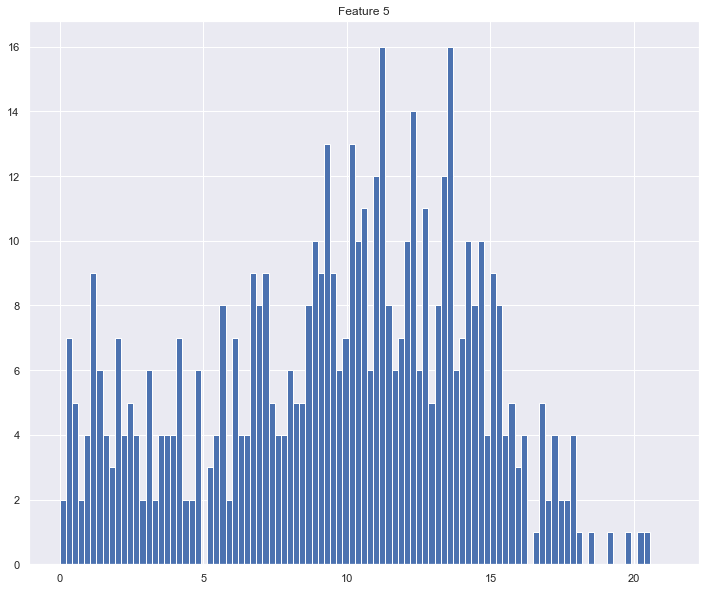

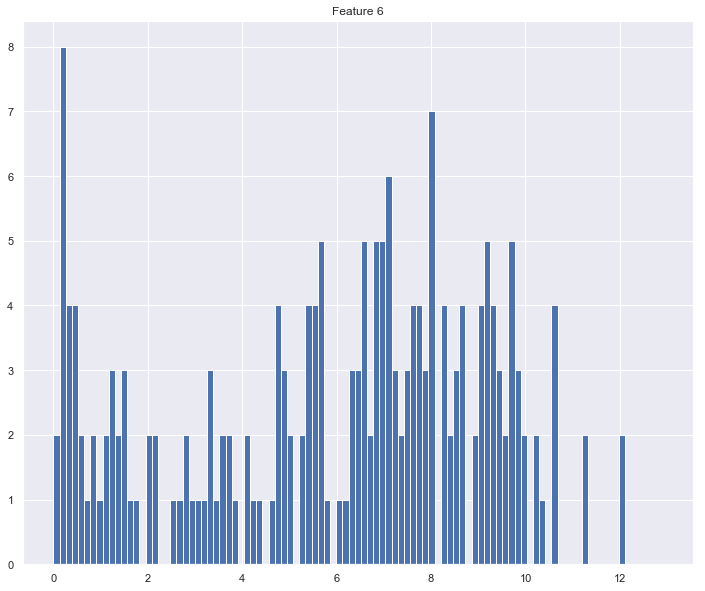

In [12]:
# histograms to "eyeball" how to define clusters
scProject.viz.patternWeightDistribution(dataset_filtered, 'MG99', [5,6], obsColumn='CellType', subset=['Microglia'], numBins=100)






In [13]:
microglia= dataset_filtered[dataset_filtered.obs['CellType'].isin(['Microglia'])]
# We are now going to construct two clusters of microglia based on feature expression of 5
C1 = microglia[microglia.obsm['MG99'][:, 4] > 5]
C2 = microglia[microglia.obsm['MG99'][:, 4] <= 5]

C1.X = np.log1p(C1.X) #log transform for statistical tests
C2.X = np.log1p(C2.X) #log transform for statistcal tests

# In order to do the regression we had to filter genes, but now we are going to use the whole feature map
mgAllGenes = dataset[dataset.obs['CellType'].isin(['Microglia'])]
# transfer regression insights
mgAllGenes.obsm['MG99'] = microglia.obsm['MG99']

cluster1 = mgAllGenes[microglia.obsm['MG99'][:, 4] > 5]
cluster2 = mgAllGenes[microglia.obsm['MG99'][:, 4] <= 5]

cluster1.X = np.log1p(cluster1.X) #log transform for stats
cluster2.X = np.log1p(cluster2.X) #log transform for stats


First, we need to check whether the expression of feature 5 is significant. scProject's featureExpressionSig allows us to test the null hypothesis that the mean expression/use of feature 5 in cluster 1 is 0 using a simple t-test. The method returns the t-value at the specified level of confidence and the t-value from the data.

In [14]:
scProject.stats.featureExpressionSig(C1, 'MG99', 5, .99999999999)

We can reject the null hypothesis that the mean is 0.


(ArrayView(72.75737733), 6.892524915703218)

Since, difference in feature expression does not guarantee (formally) difference in gene expression. We use scProject's HotellingT2 to test the null hypothesis that the mean gene expression of cluster1 and cluster2 are the same.

In [15]:
# We do not have the sample sizes to run this function on the whole feature map
scProject.stats.HotellingT2(C1, C2)

T2 Value: 8691.448218984395 FValue: 5.356878736322158 P-Value: 1.1102230246251565e-16


(ArrayView([[8691.44821898]]),
 ArrayView([[5.35687874]]),
 array([[1.11022302e-16]]))

Lastly, to find the genes driving/causing the difference in gene expression. scProject uses Bonferroni confidence intervals on the difference of the means to see which genes can be used to discriminate between the clusters. This function has to be run on the filtered feature map.

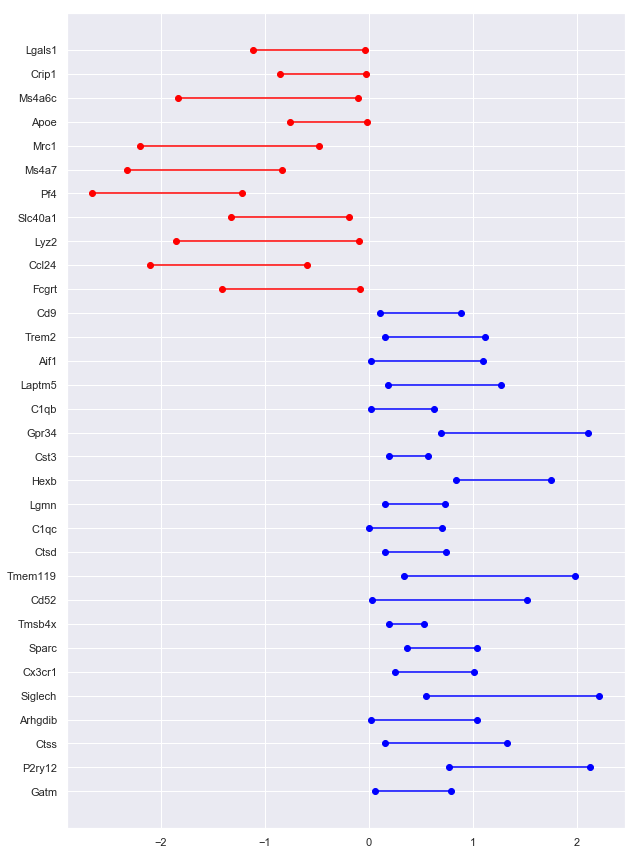

                      Low      High
gene_short_name                    
Gatm             0.062736  0.784283
Fcgrt           -1.405644 -0.087811
P2ry12           0.767025  2.121231
Ctss             0.158090  1.330358
Ccl24           -2.097282 -0.594504
Arhgdib          0.022739  1.038803
Siglech          0.553139  2.211567
Lyz2            -1.850331 -0.098702
Cx3cr1           0.248679  1.009587
Slc40a1         -1.325477 -0.192952
Pf4             -2.658468 -1.222020
Ms4a7           -2.317714 -0.830711
Sparc            0.368794  1.033831
Mrc1            -2.199075 -0.476301
Tmsb4x           0.189120  0.532876
Apoe            -0.761285 -0.015126
Ms4a6c          -1.836488 -0.099793
Crip1           -0.855834 -0.026494
Cd52             0.032027  1.515287
Lgals1          -1.112738 -0.038825
Tmem119          0.333926  1.976321
Ctsd             0.156150  0.737160
C1qc             0.004134  0.699374
Lgmn             0.153410  0.733454
Hexb             0.841328  1.749428
Cst3             0.197178  0

In [16]:
# df holds three dataframes each with slightly different information on each gene.
plt.rcParams['figure.figsize']= [10,15]
df=scProject.stats.projectionDriver(patterns_filtered, C1, C2,.999999999999,'gene_short_name', 5)

print(df[0])


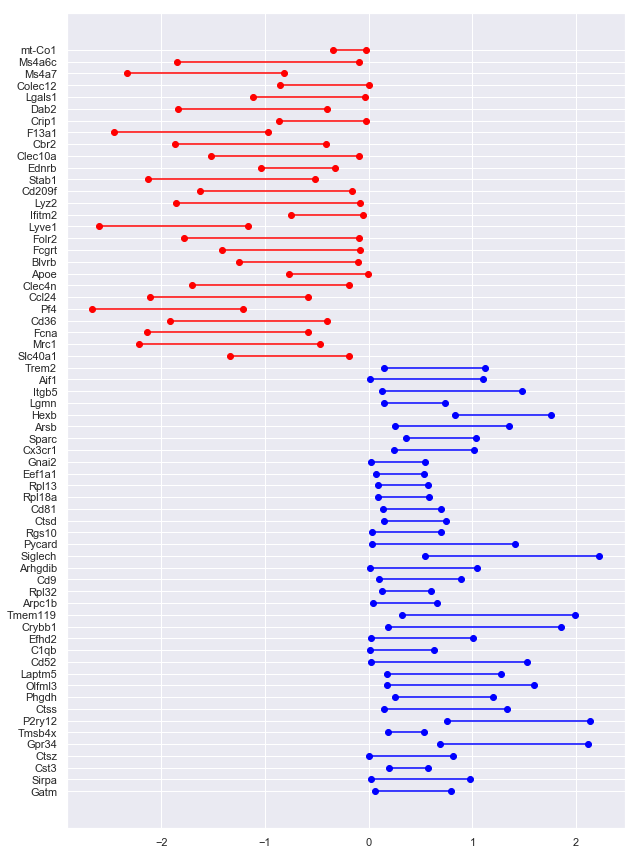

In [17]:
fullMap = scProject.stats.BonferroniCorrectedDifferenceMeans(cluster1, cluster2,.999999999999, 'gene_short_name', verbose=613)